In [1]:
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# User defined variables

In [2]:
cruise = "EN695" #['EN608', 'EN695', 'EN720', 'EN706', 'EN712', "EN661", "EN617"]
metric= "ESD" #ESD or Biovolume

In [3]:
# Parameters
cruise = "EN608"
metric = "ESD"


In [4]:
attune_dir = rf"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Attune\{cruise}\processedAttune"
ifcb_file = rf"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\IFCB\{cruise}\{cruise}_ifcb_clean.csv"
depth_file = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\depth_partitioning2.csv"
output_dir = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\IFCB_Attune"
cruise_dir = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\processed_cruises_meta.csv"
meta_path = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\ap_VolFilt.csv"
os.makedirs(output_dir, exist_ok=True)

# Load Data

## Attune

In [5]:
# Parse CxxNyy from Attune filenames
pat = re.compile(r"C(\d+)N(\d+)", re.IGNORECASE)

# Attune group volumes (mL)
GROUP_VOL = {"pro": 0.08, "syn": 0.32, "euk": 0.32}

attune_records = []

for fpath in glob.glob(os.path.join(attune_dir, "*.csv")):
    fname = os.path.basename(fpath)
    m = pat.search(fname)
    if not m:
        continue

    cast = int(m.group(1))
    niskin = int(m.group(2))

    df_a = pd.read_csv(fpath)
    df_a["cruise"] = cruise
    df_a["cast"] = cast
    df_a["niskin"] = niskin
    df_a["filename"] = fname
    df_a["source"] = "Attune"

    if "Biovolume" in df_a.columns:
        V = df_a["Biovolume"]
        GALD = 2 * ((3 * V) / (4 * np.pi)) ** (1.0 / 3.0)
        r = GALD / 2.0
        df_a["GALD"] = GALD
        df_a["ESD"] = GALD
        df_a["S_to_V"] = 6.0 / GALD
        df_a["shape_complexity"] = 1.0
        df_a["aspect_ratio"] = 1.0
        df_a["SurfaceArea"] = 4 * np.pi * (r ** 2)
        df_a["maxFeretDiameter"] = GALD
        df_a["minFeretDiameter"] = GALD
        df_a["Perimeter"] = np.pi * GALD
        df_a["Area"] = np.pi * (r ** 2)

    attune_records.append(df_a)

attune_all = pd.concat(attune_records, ignore_index=True)
print("Attune:", attune_all.shape)

Attune: (66885, 23)


## IFCB

In [6]:
# IFCB pixel to micron conversion
PX_PER_UM = 2.77

ifcb_raw = pd.read_csv(ifcb_file)
ifcb_df = ifcb_raw.copy()
ifcb = pd.DataFrame()

ifcb["cast"] = pd.to_numeric(ifcb_df["cast"], errors="coerce").astype("Int64")
ifcb["niskin"] = pd.to_numeric(ifcb_df["niskin"], errors="coerce").astype("Int64")
ifcb['ml_analyzed'] = ifcb_df['ml_analyzed']

ifcb["Biovolume"] = ifcb_df["Biovolume"] / (PX_PER_UM ** 3)
ifcb["Area"] = ifcb_df["Area"] / (PX_PER_UM ** 2)
ifcb["ESD"] = ifcb_df["EquivDiameter"] / PX_PER_UM
ifcb["maxFeretDiameter"] = ifcb_df["maxFeretDiameter"] / PX_PER_UM
ifcb["minFeretDiameter"] = ifcb_df["minFeretDiameter"] / PX_PER_UM
ifcb["Perimeter"] = ifcb_df["Perimeter"] / PX_PER_UM
ifcb["SurfaceArea"] = ifcb_df["SurfaceArea"] / (PX_PER_UM ** 2)
ifcb["GALD"] = ifcb_df["maxFeretDiameter"]
ifcb["S_to_V"] = ifcb_df["SurfaceArea"] / ifcb_df["Biovolume"]

C:\Users\ocron\AppData\Local\Temp\ipykernel_74696\3238226634.py:4: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  ifcb_raw = pd.read_csv(ifcb_file)


In [7]:
ifcb['niskin'].unique()

<IntegerArray>
[19, 5, 3, 12, 6, 16, 2, 11, 18, 22, 13, 15, 1, 7, 14, 9]
Length: 16, dtype: Int64

In [8]:
station_map = (
    ifcb_raw.dropna(subset=["station"])
    [["cruise", "cast", "niskin", "station"]]
    .drop_duplicates()
)

## Merge into one df

In [9]:
records = []

for (cast, niskin), att_sub in attune_all.groupby(["cast", "niskin"]):
    ifcb_sub = ifcb[(ifcb["cast"] == cast) & (ifcb["niskin"] == niskin)]
    if att_sub.empty or ifcb_sub.empty:
        continue

    match = station_map[
        (station_map["cast"] == cast) &
        (station_map["niskin"] == niskin)
    ]
    station_val = match["station"].iloc[0] if not match.empty else np.nan

    df_a = att_sub.copy()
    df_a["cruise"] = cruise
    df_a["station"] = station_val
    records.append(df_a)

    keep_cols = [
        "Biovolume", "ESD", "ml_analyzed",
        "GALD", "S_to_V", "shape_complexity", "aspect_ratio",
        "SurfaceArea", "maxFeretDiameter", "minFeretDiameter",
        "Perimeter", "Area",
    ]

    keep_cols = [c for c in keep_cols if c in ifcb_sub.columns]
    df_i = ifcb_sub[keep_cols].copy()
    df_i["source"] = "IFCB"
    df_i["cruise"] = cruise
    df_i["cast"] = cast
    df_i["niskin"] = niskin
    df_i["station"] = station_val
    records.append(df_i)

long_df = pd.concat(records, ignore_index=True)


In [10]:
long_df['niskin'].unique()

array([ 5, 19, 12, 16, 11, 18, 13, 22, 15, 14,  9])

In [11]:
long_df = long_df[['cruise', 'cast', 'niskin', 'station', 'class', 'group', 'depth_m', 'datetime',
       'ap_vol', 'filename', 'source',  'Biovolume', 'ml_analyzed', 'GALD', 'S_to_V', 'shape_complexity', 'aspect_ratio', 
        'SurfaceArea', 'maxFeretDiameter', 'minFeretDiameter', 'Perimeter', 'Area', 'ESD']]

# Figure out Thresholds for IFCB vs Attune Overlap

In [12]:
n_coarse = 20
min_pairs = 1
tol_log = 0.5

In [13]:
vmin_global = min(attune_all[metric].min(), ifcb[metric].min())
vmax_global = max(attune_all[metric].max(), ifcb[metric].max())

coarse_bins = np.logspace(np.log10(vmin_global),
                          np.log10(vmax_global),
                          n_coarse + 1)
coarse_mid = np.sqrt(coarse_bins[:-1] * coarse_bins[1:])
vmax_global

146.01408267148014

In [14]:
records = []

for (cast, niskin), att_sub in attune_all.groupby(["cast", "niskin"]):
    ifcb_sub = ifcb[(ifcb["cast"] == cast) & (ifcb["niskin"] == niskin)]
    if att_sub.empty or ifcb_sub.empty:
        continue

    if "group" not in att_sub.columns:
        continue

    att_euk = att_sub[att_sub["group"].str.lower() == "euk"].copy()
    if att_euk.empty:
        continue

    V_att_euk = GROUP_VOL["euk"]
    V_ifcb = ifcb_sub["ml_analyzed"].dropna().unique().sum()

    counts_att, _ = np.histogram(att_euk[metric], bins=coarse_bins)
    counts_ifcb, _ = np.histogram(ifcb_sub[metric], bins=coarse_bins)

    conc_att = counts_att.astype(float) / V_att_euk
    conc_ifcb = counts_ifcb.astype(float) / V_ifcb

    for k in range(len(coarse_mid)):
        records.append({
            "cast": cast,
            "niskin": niskin,
            "bin_idx": k,
            "bin_mid": coarse_mid[k],
            "bin_left": coarse_bins[k],
            "bin_right": coarse_bins[k + 1],
            "conc_att_euk": conc_att[k],
            "conc_ifcb": conc_ifcb[k],
        })

cruise_comp = pd.DataFrame(records)
print("cruise_comp:", cruise_comp.shape)


cruise_comp: (400, 8)


In [15]:
# per-bin residual statistics
df_overlap = cruise_comp[
    (cruise_comp["conc_att_euk"] > 0) &
    (cruise_comp["conc_ifcb"] > 0)
].copy()

df_overlap["log_att"] = np.log10(df_overlap["conc_att_euk"])
df_overlap["log_ifcb"] = np.log10(df_overlap["conc_ifcb"])
df_overlap["resid"] = df_overlap["log_ifcb"] - df_overlap["log_att"]

per_bin = (
    df_overlap.groupby("bin_idx")
    .agg(
        bin_mid=("bin_mid", "first"),
        bin_left=("bin_left", "first"),
        bin_right=("bin_right", "first"),
        n_pairs=("resid", "count"),
        med_resid=("resid", "median"),
        mad_resid=("resid", lambda x: np.median(np.abs(x - np.median(x)))),
    )
    .reset_index()
)

per_bin

,bin_idx,bin_mid,bin_left,bin_right,n_pairs,med_resid,mad_resid
0,9,2.775271,2.297993,3.351676,20,-1.917462,0.176223
1,10,4.047796,3.351676,4.888496,20,0.049567,0.121221
2,11,5.903804,4.888496,7.129984,20,0.625753,0.187147
3,12,8.610833,7.129984,10.399245,20,0.333563,0.144902
4,13,12.559098,10.399245,15.167538,20,-0.232408,0.176847
5,14,18.317733,15.167538,22.122202,15,-0.169282,0.190176
6,15,26.716835,22.122202,32.265741,9,-0.178678,0.279589
7,16,38.967117,32.265741,47.060324,6,-0.713100,0.113319


In [16]:
per_bin["good"] = (
    (per_bin["n_pairs"] >= min_pairs) &
    (per_bin["med_resid"].abs() <= tol_log)
)

good = per_bin["good"].to_numpy()
run_id = np.zeros_like(good, dtype=int)
current = 0
for i, flag in enumerate(good):
    if flag:
        if i == 0 or not good[i - 1]:
            current += 1
        run_id[i] = current

per_bin["run_id"] = run_id
per_bin

,bin_idx,bin_mid,bin_left,bin_right,n_pairs,med_resid,mad_resid,good,run_id
0,9,2.775271,2.297993,3.351676,20,-1.917462,0.176223,False,0
1,10,4.047796,3.351676,4.888496,20,0.049567,0.121221,True,1
2,11,5.903804,4.888496,7.129984,20,0.625753,0.187147,False,0
3,12,8.610833,7.129984,10.399245,20,0.333563,0.144902,True,2
4,13,12.559098,10.399245,15.167538,20,-0.232408,0.176847,True,2
5,14,18.317733,15.167538,22.122202,15,-0.169282,0.190176,True,2
6,15,26.716835,22.122202,32.265741,9,-0.178678,0.279589,True,2
7,16,38.967117,32.265741,47.060324,6,-0.713100,0.113319,False,0


In [17]:
runs = per_bin[per_bin["run_id"] > 0]

if runs.empty:
    print("No overlap region found.")
    L_cut = None
    U_cut = None
else:
    run_lengths = runs.groupby("run_id")["bin_idx"].count()
    best_run_id = run_lengths.idxmax()
    best_run = per_bin[per_bin["run_id"] == best_run_id]

    L_cut = best_run["bin_left"].min()
    U_cut = best_run["bin_right"].max()

    print("Overlap range:")
    print(f"  L_cut ~ {L_cut:.1f} µm³")
    print(f"  U_cut ~ {U_cut:.1f} µm³")

Overlap range:
  L_cut ~ 7.1 µm³
  U_cut ~ 32.3 µm³


In [18]:
accepted_bins = best_run["bin_idx"].astype(int).to_numpy()

pad = 2
max_bin = int(per_bin["bin_idx"].max())

bins_to_show = sorted({
    b2
    for b in accepted_bins
    for b2 in range(int(b) - pad, int(b) + pad + 1)
    if 0 <= b2 <= max_bin
})

In [19]:
def plot_bin_scatter_grid(cruise_comp, bins_to_show, good_bins=None):
    n = len(bins_to_show)
    ncols = 4
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
    axes = axes.ravel()

    good_bins = set(good_bins) if good_bins is not None else set()

    for ax, k in zip(axes, bins_to_show):
        sub = cruise_comp[
            (cruise_comp["bin_idx"] == k) &
            (cruise_comp["conc_att_euk"] > 0) &
            (cruise_comp["conc_ifcb"] > 0)
        ]
        if sub.empty:
            ax.axis("off")
            continue

        ax.scatter(sub["conc_att_euk"], sub["conc_ifcb"], s=10, alpha=0.6)

        xy_min = min(sub[["conc_att_euk", "conc_ifcb"]].min())
        xy_max = max(sub[["conc_att_euk", "conc_ifcb"]].max())
        ax.plot([xy_min, xy_max], [xy_min, xy_max], "k--", lw=1)

        bleft = sub["bin_left"].iloc[0]
        bright = sub["bin_right"].iloc[0]

        tag = "✓" if k in good_bins else ""
        ax.set_title(f"{tag} bin {k}: {bleft:.2f}–{bright:.2f}", fontsize=9)

        ax.set_xscale("log")
        ax.set_yscale("log")

    # turn off unused axes
    for ax in axes[len(bins_to_show):]:
        ax.axis("off")

    for ax in axes[:len(bins_to_show)]:
        if ax.has_data():
            ax.set_xlabel("Attune euk conc (cells mL⁻¹)")
            ax.set_ylabel("IFCB conc (cells mL⁻¹)")

    plt.tight_layout()
    plt.show()


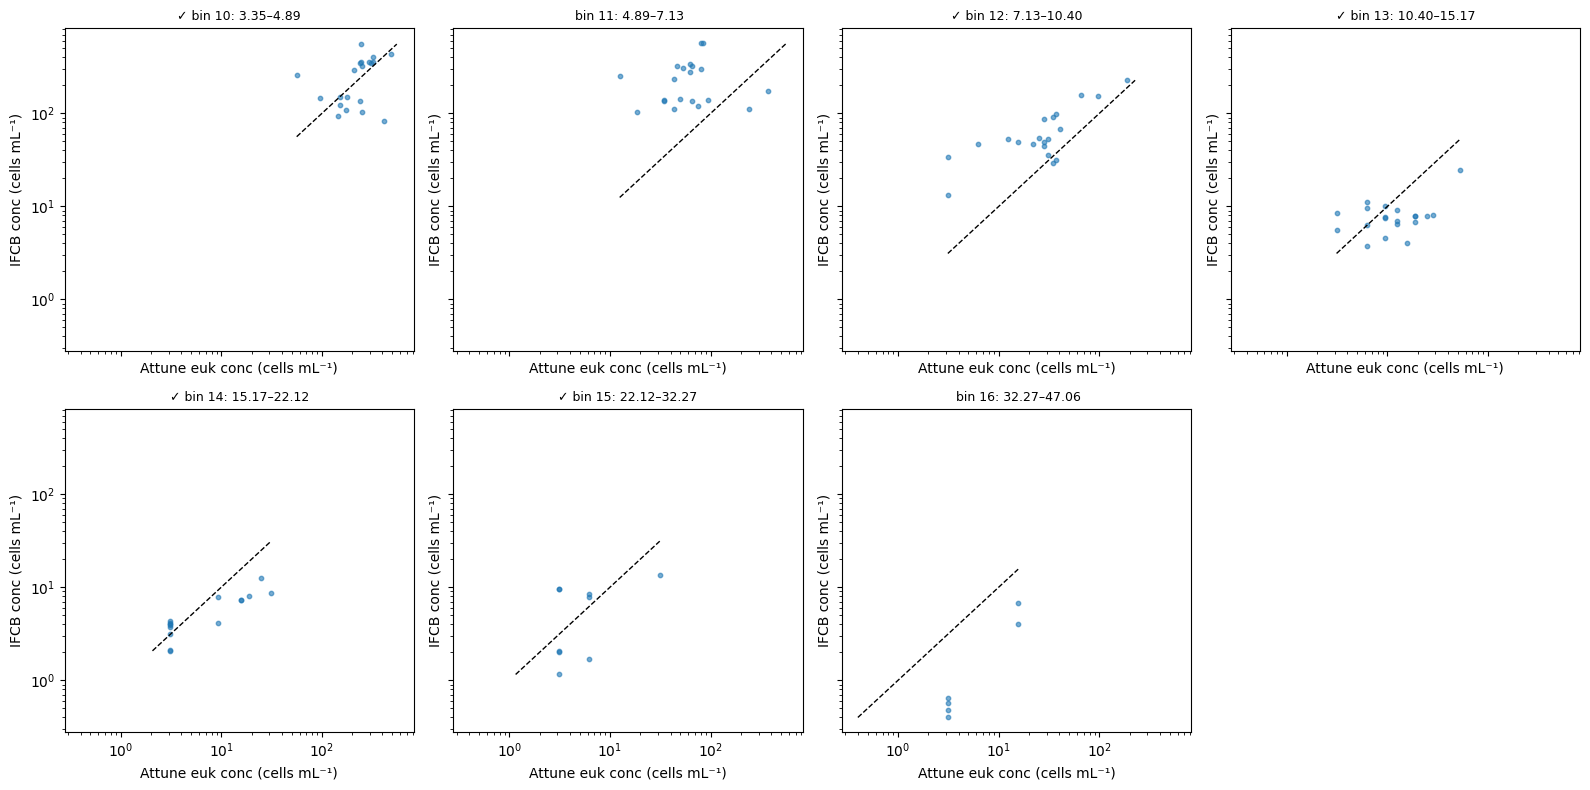

In [20]:
good_bins = per_bin.loc[per_bin["good"], "bin_idx"].astype(int).tolist()

plot_bin_scatter_grid(
    cruise_comp,
    bins_to_show=bins_to_show,
    good_bins=good_bins
)


# Merge Attune and IFCB Euks based on Overlap and Convert to Concentrations

In [21]:
pairs = (
    long_df[["cast", "niskin"]]
    .drop_duplicates()
    .sort_values(["cast", "niskin"])
    .itertuples(index=False, name=None)
)

#pairs_list = list(pairs)
#pairs_list[:30]   # peek at the first 20

In [22]:
merged_dfs = []

for cast_val, niskin_val in pairs:
    sub = long_df[(long_df["cast"] == cast_val) &
                  (long_df["niskin"] == niskin_val)]

    sub_att = sub[sub["source"] == "Attune"].copy()
    sub_ifcb = sub[sub["source"] == "IFCB"].copy()
    if sub_att.empty or sub_ifcb.empty:
        continue

    vmin = min(sub_att[metric].min(), sub_ifcb[metric].min())
    vmax = max(sub_att[metric].max(), sub_ifcb[metric].max())
    n_bins = 80
    bins = np.logspace(np.log10(vmin), np.log10(vmax), n_bins + 1)
    bin_mid = np.sqrt(bins[:-1] * bins[1:])
    bin_width = np.diff(bins)
    #bin_width = np.diff(np.log10(bins))

    conc_pro = np.zeros(n_bins)
    conc_syn = np.zeros(n_bins)
    conc_euk = np.zeros(n_bins)

    for g in ["pro", "syn", "euk"]:
        if "group" not in sub_att.columns:
            continue
        gsub = sub_att[sub_att["group"].str.lower() == g]
        if gsub.empty:
            continue

        Vg = GROUP_VOL[g]
        counts_g, _ = np.histogram(gsub[metric], bins=bins)
        conc_g = counts_g.astype(float) / Vg

        if g == "pro":
            conc_pro = conc_g
        elif g == "syn":
            conc_syn = conc_g
        elif g == "euk":
            conc_euk = conc_g

    conc_att_total = conc_pro + conc_syn + conc_euk

    V_ifcb = sub_ifcb["ml_analyzed"].dropna().unique().sum()
    counts_ifcb, _ = np.histogram(sub_ifcb[metric], bins=bins)
    conc_ifcb = counts_ifcb.astype(float) / V_ifcb

    psd_pro = conc_pro / bin_width
    psd_syn = conc_syn / bin_width
    psd_euk_att = conc_euk / bin_width
    psd_ifcb = conc_ifcb / bin_width

    psd_euk_merge = np.zeros_like(psd_euk_att)

    for i, bmid in enumerate(bin_mid):
        if L_cut is None or U_cut is None:
            psd_euk_merge[i] = psd_euk_att[i]
        else:
            if bmid <= L_cut:
                psd_euk_merge[i] = psd_euk_att[i]
            elif bmid >= U_cut:
                psd_euk_merge[i] = psd_ifcb[i]
            else:
                V_att_euk = GROUP_VOL["euk"]
                num = psd_euk_att[i] * V_att_euk + psd_ifcb[i] * V_ifcb
                den = V_att_euk + V_ifcb
                psd_euk_merge[i] = num / den

    psd_att_total = psd_pro + psd_syn + psd_euk_att
    psd_total_merged = psd_pro + psd_syn + psd_euk_merge

    cruise_val = sub["cruise"].iloc[0]
    station_val = sub["station"].dropna().iloc[0] if sub["station"].notna().any() else np.nan

    df_bottle = pd.DataFrame({
        "cruise": cruise_val,
        "cast": cast_val,
        "niskin": niskin_val,
        "station": station_val,
        "bin_idx": np.arange(n_bins),
        "bin_mid": bin_mid,
        "bin_left": bins[:-1],
        "bin_right": bins[1:],
        "psd_pro": psd_pro,
        "psd_syn": psd_syn,
        "psd_euk_att": psd_euk_att,
        "psd_euk_merge": psd_euk_merge,
        "psd_ifcb": psd_ifcb,
        "psd_att_total": psd_att_total,
        "psd_total_merged": psd_total_merged,
        "L_cut": L_cut,
        "U_cut": U_cut,
    })

    merged_dfs.append(df_bottle)

if merged_dfs:
    merged_all = pd.concat(merged_dfs, ignore_index=True)
else:
    merged_all = pd.DataFrame()

In [23]:
print("merged_all rows:", merged_all.shape[0])
print(
    merged_all[["cast", "niskin"]]
    .drop_duplicates()
    .sort_values(["cast", "niskin"])
)


merged_all rows: 1600
      cast  niskin
0        1       5
80       1      19
160      4      12
240      8      12
320      8      16
400      9      16
480     12      11
560     12      18
640     14      13
720     14      22
800     15      11
880     15      15
960     15      19
1040    19      11
1120    19      18
1200    21      14
1280    21      19
1360    22      13
1440    22      19
1520    30       9


In [24]:
merged_all['niskin'].unique()

array([ 5, 19, 12, 16, 11, 18, 13, 22, 15, 14,  9])

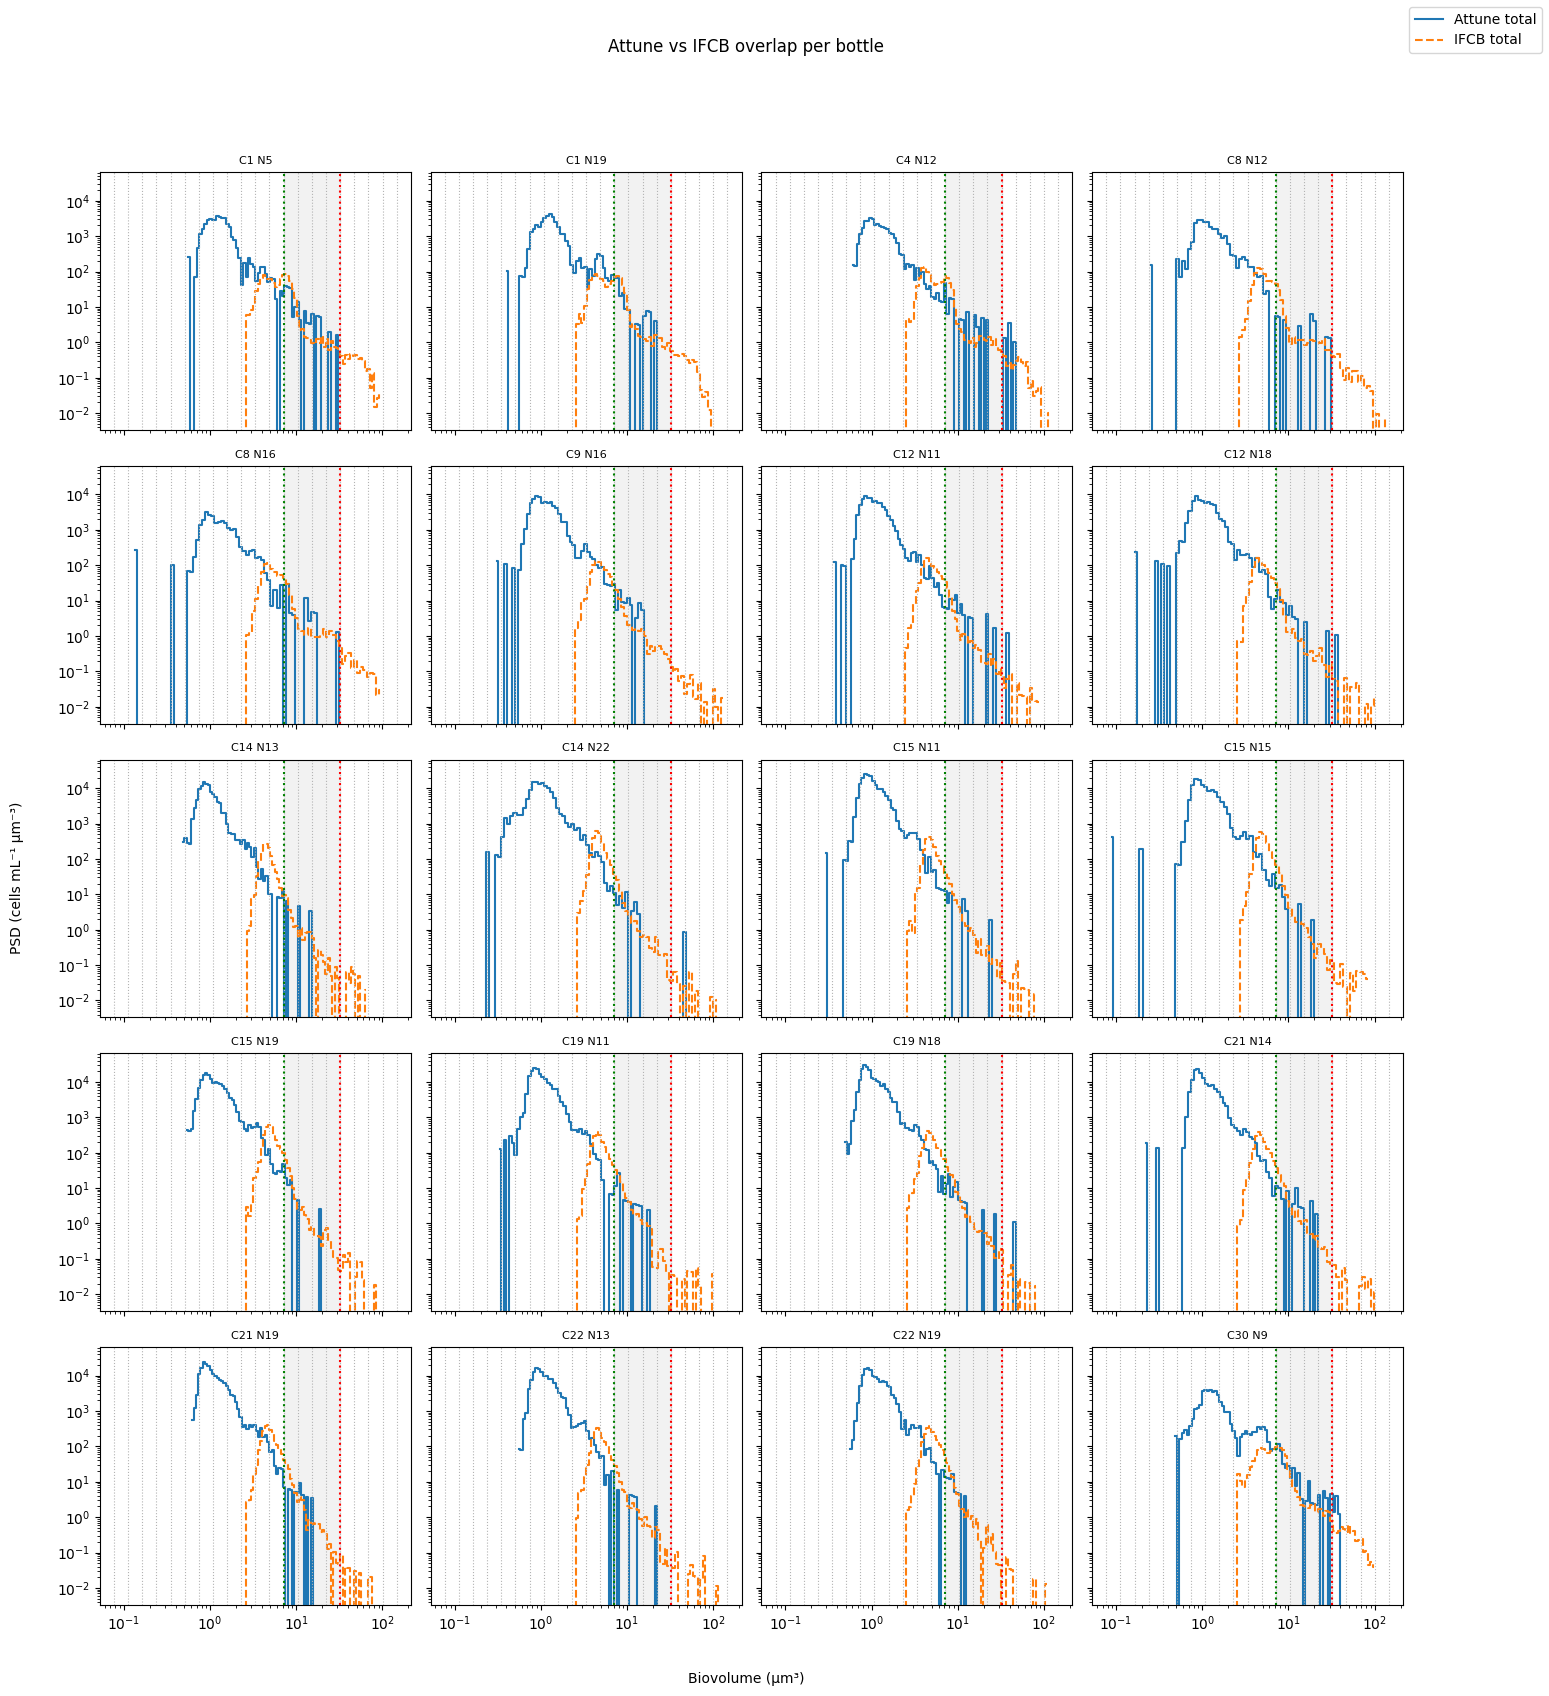

In [25]:
def plot_overlap_grid(merged_all, L_cut, U_cut, coarse_bins, max_panels=12):
    """
    Multi-panel: each panel is one cast/niskin.
    Shows overlap histogram style Attune vs IFCB PSD for selected bottles.
    """
    grouped = merged_all.groupby(["cast", "niskin"], sort=True)
    groups_list = list(grouped)

    if max_panels is not None:
        groups_list = groups_list[:max_panels]

    nplots = len(groups_list)
    if nplots == 0:
        print("No bottles to plot in overlap grid.")
        return

    ncols = 4
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4 * ncols, 3.5 * nrows),
        sharex=True, sharey=True,
    )
    axes = axes.ravel()

    for ax, ((cval, nval), df_b) in zip(axes, groups_list):
        bm = df_b["bin_mid"].to_numpy()
        left = df_b["bin_left"].to_numpy()
        right = df_b["bin_right"].to_numpy()
        width = right - left

        psd_att_total = df_b["psd_att_total"].to_numpy()
        psd_ifcb = df_b["psd_ifcb"].to_numpy()

        # back out conc per bin from PSD
        conc_att = psd_att_total * width
        conc_ifcb = psd_ifcb * width

        ax.axvspan(L_cut, U_cut, color="0.9", alpha=0.5)

        ax.step(bm, conc_att / width, where="mid", label="Attune total")
        ax.step(bm, conc_ifcb / width, where="mid", ls="--", label="IFCB total")

        for edge in coarse_bins:
            ax.axvline(edge, color="0.7", lw=0.8, ls=":")

        ax.axvline(L_cut, color="green", lw=1.5, ls=":")
        ax.axvline(U_cut, color="red", lw=1.5, ls=":")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(f"C{cval} N{nval}", fontsize=8)

    for ax in axes[nplots:]:
        ax.axis("off")

    fig.text(0.5, 0.04, "Biovolume (µm³)", ha="center")
    fig.text(0.04, 0.5, "PSD (cells mL⁻¹ µm⁻³)", va="center", rotation="vertical")
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right")
    fig.suptitle("Attune vs IFCB overlap per bottle", y=0.98)
    plt.tight_layout(rect=[0.06, 0.06, 0.92, 0.94])
    plt.show()

# multipanel overlap QC (Attune vs IFCB PSD)
plot_overlap_grid(merged_all, L_cut, U_cut, coarse_bins, max_panels=None)

In [26]:
def plot_merged_psd_grid(merged_all, max_panels=None):
    """
    Multi-panel: final merged PSD per bottle (merged total + IFCB).
    """
    grouped = merged_all.groupby(["cast", "niskin"], sort=True)
    #groups_list = list(grouped.items())
    groups_list = [(key, df) for key, df in grouped]
    if max_panels is not None:
        groups_list = groups_list[:max_panels]

    nplots = len(groups_list)
    if nplots == 0:
        print("No bottles to plot in merged PSD grid.")
        return

    ncols = 4
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4 * ncols, 3.5 * nrows),
        sharex=True, sharey=True,
    )
    axes = axes.ravel()

    for ax, ((cval, nval), df_b) in zip(axes, groups_list):
        bm = df_b["bin_mid"].to_numpy()
        psd_tot = df_b["psd_total_merged"].to_numpy()
        psd_ifcb = df_b["psd_ifcb"].to_numpy()

        ax.step(bm, psd_tot, where="mid", color="black", lw=1.5, label="Merged total")
        ax.step(bm, psd_ifcb, where="mid", color="tab:purple", ls="--", lw=1, label="IFCB")

        L_cut = df_b["L_cut"].iloc[0]
        U_cut = df_b["U_cut"].iloc[0]
        ax.axvline(L_cut, color="green", ls=":", lw=1)
        ax.axvline(U_cut, color="green", ls=":", lw=1)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(f"C{cval} N{nval}", fontsize=8)

    for ax in axes[nplots:]:
        ax.axis("off")

    fig.text(0.5, 0.04, "Biovolume (µm³)", ha="center")
    fig.text(0.04, 0.5, "PSD (cells mL⁻¹ µm⁻³)", va="center", rotation="vertical")
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles[:2], labels[:2], loc="upper right")
    fig.suptitle("Merged PSD per bottle", y=0.98)
    plt.tight_layout(rect=[0.06, 0.06, 0.92, 0.94])
    plt.show()
    
# multipanel final merged PSD QC
#plot_merged_psd_grid(merged_all, max_panels=None)


# Get PSD Slope

## Add depths

In [27]:
depth_df = pd.read_csv(depth_file)

ap_meta = pd.read_csv(meta_path)

# standardize types
depth_df["cruise"] = depth_df["cruise"].astype(str).str.lower()
depth_df["cast"]   = pd.to_numeric(depth_df["cast"], errors="coerce").astype("Int64")
depth_df["niskin"] = pd.to_numeric(depth_df["niskin"], errors="coerce").astype("Int64")

In [28]:
cruise_meta = pd.read_csv(cruise_dir)

counts_df = (
    cruise_meta
    .rename(columns={"Cruise": "cruise"})
    .merge(
        depth_df,
        on=["cruise"],
        how="left",
    )
)

In [29]:
def norm_keys(df):
    df = df.copy()
    df["cruise"] = df["cruise"].astype(str).str.strip().str.lower()
    df["cast"]   = pd.to_numeric(df["cast"], errors="coerce").astype("Int64")
    df["niskin"] = pd.to_numeric(df["niskin"], errors="coerce").astype("Int64")
    return df

counts_df2 = norm_keys(counts_df)
ap_meta2   = norm_keys(ap_meta)

counts_df2 = counts_df2.merge(
    ap_meta2[["cruise","cast","niskin","station"]].drop_duplicates(["cruise","cast","niskin"]),
    on=["cruise","cast","niskin"],
    how="left"
)

In [30]:
sample_counts = (
    counts_df2
    .query("season in ['Summer', 'Winter'] and depth_cat in ['Surface', 'DCM']")
    .dropna(subset=["season", "depth_cat", "station"])
    .groupby(["season", "depth_cat", "station"])
    .size()
    .reset_index(name="n_samples")
    .sort_values("n_samples", ascending=True)
)


In [31]:
season_depth_counts = (
    counts_df
    .dropna(subset=["season", "depth_cat", "cast", "niskin"])
    .drop_duplicates(subset=["season", "depth_cat", "cast", "niskin"])
    .groupby(["season", "depth_cat"])
    .size()
    .reset_index(name="n_cast_niskin")
)

print(season_depth_counts)

    season depth_cat  n_cast_niskin
0     Fall       DCM             23
1     Fall     Other              8
2     Fall   Surface             19
3   Spring       DCM             21
4   Spring     Other              8
5   Spring   Surface             22
6   Summer       DCM             43
7   Summer     Other             27
8   Summer   Surface             43
9   Winter       DCM             36
10  Winter     Other             18
11  Winter   Surface             39


In [32]:
merged_all["cruise"] = merged_all["cruise"].astype(str).str.lower()
merged_all["cast"]   = pd.to_numeric(merged_all["cast"], errors="coerce").astype("Int64")
merged_all["niskin"] = pd.to_numeric(merged_all["niskin"], errors="coerce").astype("Int64")

# add depth category
merged_all = merged_all.merge(
    depth_df[["cruise", "cast", "niskin", "depth_cat"]],
    on=["cruise", "cast", "niskin"],
    how="left",
)

In [33]:
merged_all_simple = (
    merged_all[["cruise", "cast", "niskin", "depth_cat"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
merged_all_simple

,cruise,cast,niskin,depth_cat
0,en608,1,5,NaN
1,en608,1,19,Surface
2,en608,4,12,Surface
3,en608,8,12,NaN
4,en608,8,16,Surface
5,en608,9,16,Surface
6,en608,12,11,NaN
7,en608,12,18,Surface
8,en608,14,13,DCM
9,en608,14,22,Surface


In [34]:
merged_all2 = merged_all.dropna(subset=["depth_cat"]).query("depth_cat != 'Other'").copy()

In [35]:
merged_all2['niskin'].unique()

<IntegerArray>
[19, 12, 16, 18, 13, 22, 15, 11, 9]
Length: 9, dtype: Int64

In [36]:
merged_all = merged_all2

In [37]:
merged_all.columns


Index(['cruise', 'cast', 'niskin', 'station', 'bin_idx', 'bin_mid', 'bin_left',
       'bin_right', 'psd_pro', 'psd_syn', 'psd_euk_att', 'psd_euk_merge',
       'psd_ifcb', 'psd_att_total', 'psd_total_merged', 'L_cut', 'U_cut',
       'depth_cat'],
      dtype='object')

## Trim

In [38]:
# Trim  (MASTER WINDOW DEFINED IN ESD, Biovolume DERIVED)

import numpy as np

# 1) Set your ecological fit window ONCE in ESD space (µm)
ESD_FIT_MIN = 1.0
ESD_FIT_MAX = 20.0

def esd_to_biovolume_um3(D_um):
    """Volume of a sphere with diameter D (µm) in µm^3."""
    return (np.pi / 6.0) * (D_um ** 3)

# 2) Derive the equivalent biovolume window (µm^3)
BIO_FIT_MIN = esd_to_biovolume_um3(ESD_FIT_MIN)
BIO_FIT_MAX = esd_to_biovolume_um3(ESD_FIT_MAX)

# 3) Choose the correct window for the current run
# metric is your existing user variable near the top: metric = "ESD" or "Biovolume"
if metric == "ESD":
    XMIN, XMAX = ESD_FIT_MIN, ESD_FIT_MAX
    XUNITS = "µm"
elif metric == "Biovolume":
    XMIN, XMAX = BIO_FIT_MIN, BIO_FIT_MAX
    XUNITS = "µm³"
else:
    raise ValueError(f"Unknown metric '{metric}'. Expected 'ESD' or 'Biovolume'.")

print(f"[Trim window] metric={metric}  XMIN={XMIN:.4g} {XUNITS}  XMAX={XMAX:.4g} {XUNITS}")


[Trim window] metric=ESD  XMIN=1 µm  XMAX=20 µm


In [39]:
def trim_psd_per_bottle_abs(
    df,
    psd_col="psd_total_merged",
    x_col="bin_mid",
    group_cols=("cruise", "cast", "niskin"),
    xmin=None,
    xmax=None,
):
    """
    Trim PSD bins within absolute [xmin, xmax] for each bottle (group),
    keeping only positive, finite PSD and finite x.
    """
    if xmin is None or xmax is None:
        raise ValueError("xmin and xmax must be provided for absolute trimming.")

    trimmed_groups = []

    for keys, grp in df.groupby(list(group_cols)):
        mask_valid = (
            np.isfinite(grp[x_col]) &
            np.isfinite(grp[psd_col]) &
            (grp[psd_col] > 0)
        )
        g = grp.loc[mask_valid].copy()
        if g.empty:
            continue

        g = g[(g[x_col] >= xmin) & (g[x_col] <= xmax)].copy()
        if not g.empty:
            trimmed_groups.append(g)

    return pd.concat(trimmed_groups, ignore_index=True) if trimmed_groups else pd.DataFrame()


In [40]:
merged_trim = trim_psd_per_bottle_abs(
    merged_all,
    psd_col="psd_total_merged",
    xmin=XMIN, xmax=XMAX,
    group_cols=("cruise", "cast", "niskin"),
)

C:\Users\ocron\AppData\Local\Temp\ipykernel_74696\2094569700.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(y, x)


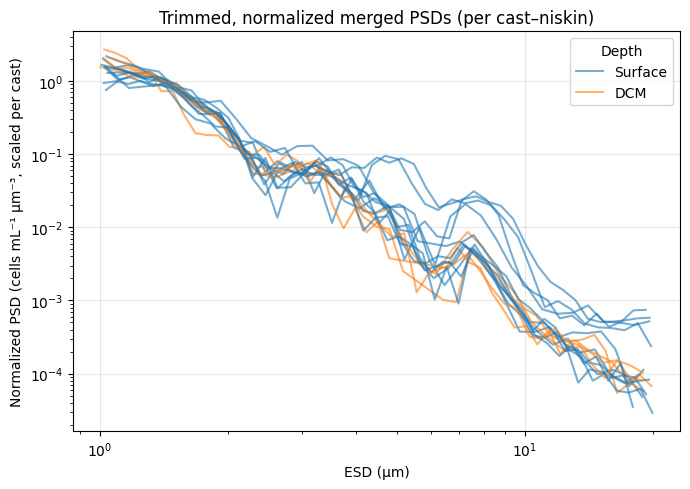

In [41]:
fig, ax = plt.subplots(figsize=(7, 5))
psd_col = "psd_total_merged"

def normalize_psd(x, y):
    # normalize by integral so each cast has the same total
    area = np.trapz(y, x)
    return y / area if area > 0 else y

for (cruise, cast, niskin), grp in merged_trim.groupby(["cruise", "cast", "niskin"]):

    x = grp["bin_mid"].to_numpy()
    y = grp[psd_col].to_numpy()
    y_norm = normalize_psd(x, y)

    if "depth_cat" in grp.columns:
        depth = str(grp["depth_cat"].iloc[0])
        if depth.lower().startswith("surf"):
            color = "tab:blue"
            label = "Surface"
        else:
            color = "tab:orange"
            label = "DCM"
    else:
        color = "tab:gray"
        label = None

    # only label the first of each depth category to avoid legend spam
    if label is not None:
        if not any(l == label for l in ax.get_legend_handles_labels()[1]):
            ax.plot(x, y_norm, color=color, alpha=0.6, label=label)
        else:
            ax.plot(x, y_norm, color=color, alpha=0.6)
    else:
        ax.plot(x, y_norm, color=color, alpha=0.6)

ax.set_xscale("log")
ax.set_yscale("log")
if metric == "Biovolume":
    ax.set_xlabel("Biovolume (µm³)")
else:
    ax.set_xlabel("ESD (µm)")
ax.set_ylabel("Normalized PSD (cells mL⁻¹ µm⁻³, scaled per cast)")
ax.set_title("Trimmed, normalized merged PSDs (per cast–niskin)")
ax.grid(alpha=0.3)

if ax.get_legend_handles_labels()[0]:
    ax.legend(title="Depth")

plt.tight_layout()
plt.show()


## Smooth

In [42]:
def smooth_psd_per_bottle(df, psd_col="psd_total_merged",
                          window=5):
    """
    For each cast–niskin, smooth log10(PSD) with a centered rolling mean.
    Edge bins use smaller windows (min_periods=1) to avoid big artifacts.
    """
    df_smooth = df.copy()
    new_col = psd_col + "_smooth"
    df_smooth[new_col] = np.nan

    for (cast, niskin), grp in df_smooth.groupby(["cast", "niskin"]):
        idx = grp.index
        y = grp[psd_col].to_numpy()

        mask_pos = (y > 0) & np.isfinite(y)
        if mask_pos.sum() == 0:
            df_smooth.loc[idx, new_col] = y
            continue

        logy = np.full_like(y, np.nan, dtype=float)
        logy[mask_pos] = np.log10(y[mask_pos])

        s = pd.Series(logy)
        logy_smooth = s.rolling(window=window, center=True,
                                min_periods=1).mean().to_numpy()

        y_smooth = np.where(np.isfinite(logy_smooth), 10**logy_smooth, np.nan)
        df_smooth.loc[idx, new_col] = y_smooth

    return df_smooth


In [43]:
merged_trim["psd_total_merged"] = (
    merged_trim["psd_syn"] + merged_trim["psd_euk_merge"]
)

merged_smooth = smooth_psd_per_bottle(
    merged_trim,
    psd_col="psd_total_merged"
)

C:\Users\ocron\AppData\Local\Temp\ipykernel_74696\2459068255.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(y, x)


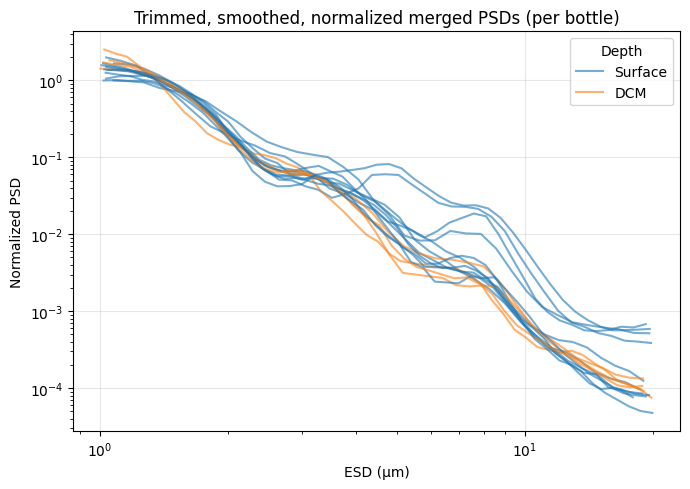

In [44]:
merged_smooth = smooth_psd_per_bottle(
    merged_trim,
    psd_col="psd_total_merged"
)

fig, ax = plt.subplots(figsize=(7, 5))
psd_col = "psd_total_merged_smooth"

def normalize_psd(x, y):
    area = np.trapz(y, x)
    return y / area if area > 0 else y

for (cruise, cast, niskin), grp in merged_smooth.groupby(
    ["cruise", "cast", "niskin"]
):
    x = grp["bin_mid"].to_numpy()
    y = grp[psd_col].to_numpy()

    mask = np.isfinite(x) & np.isfinite(y) & (y > 0)
    x = x[mask]
    y = y[mask]
    if len(x) == 0:
        continue

    y_norm = normalize_psd(x, y)

    depth = str(grp["depth_cat"].iloc[0])
    color = "tab:blue" if depth.lower().startswith("surf") else "tab:orange"
    label = "Surface" if depth.lower().startswith("surf") else "DCM"

    if label not in ax.get_legend_handles_labels()[1]:
        ax.plot(x, y_norm, color=color, alpha=0.6, label=label)
    else:
        ax.plot(x, y_norm, color=color, alpha=0.6)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ESD (µm)" if metric != "Biovolume" else "Biovolume (µm³)")
ax.set_ylabel("Normalized PSD")
ax.set_title("Trimmed, smoothed, normalized merged PSDs (per bottle)")
ax.grid(alpha=0.3)
ax.legend(title="Depth")
plt.tight_layout()
plt.show()


## Extract Slopes

In [45]:
def fit_psd_window_slope(df_group,
                         psd_col="psd_total_merged_smooth",
                         min_bins=5):
    """
    Fit PSD slope over the full trimmed window (no peak logic).
    Assumes df_group is already trimmed to the desired x-range.
    Returns: slope, intercept, r2, n_points, v_min_fit, v_max_fit
    """
    x = df_group["bin_mid"].to_numpy()
    y = df_group[psd_col].to_numpy()

    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]

    order = np.argsort(x)
    x = x[order]
    y = y[order]

    if x.size < min_bins:
        return np.nan, np.nan, np.nan, 0, np.nan, np.nan

    logx = np.log10(x)
    logy = np.log10(y)

    m, b = np.polyfit(logx, logy, 1)
    y_pred = m * logx + b
    ss_res = np.sum((logy - y_pred) ** 2)
    ss_tot = np.sum((logy - np.mean(logy)) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    return m, b, r2, x.size, x.min(), x.max()


In [46]:
slope_rows = []   # <-- THIS LINE is missing

for (cruise_val, cval, nval), grp in merged_smooth.groupby(["cruise", "cast", "niskin"]):

    slope, intercept, r2, n_pts, v_min_fit, v_max_fit = fit_psd_window_slope(
        grp,
        psd_col="psd_total_merged_smooth",
        min_bins=5,
    )

    slope_rows.append({
        "cruise": grp["cruise"].iloc[0],
        "cast": cval,
        "niskin": nval,
        "station": grp["station"].dropna().iloc[0] if grp["station"].notna().any() else np.nan,
        "depth_cat": grp["depth_cat"].iloc[0],
        f"{metric}_PSD_slope": slope,
        f"{metric}_PSD_intercept": intercept,
        "v_min_fit": v_min_fit,
        "v_max_fit": v_max_fit,
    })

slope_df = pd.DataFrame(slope_rows)


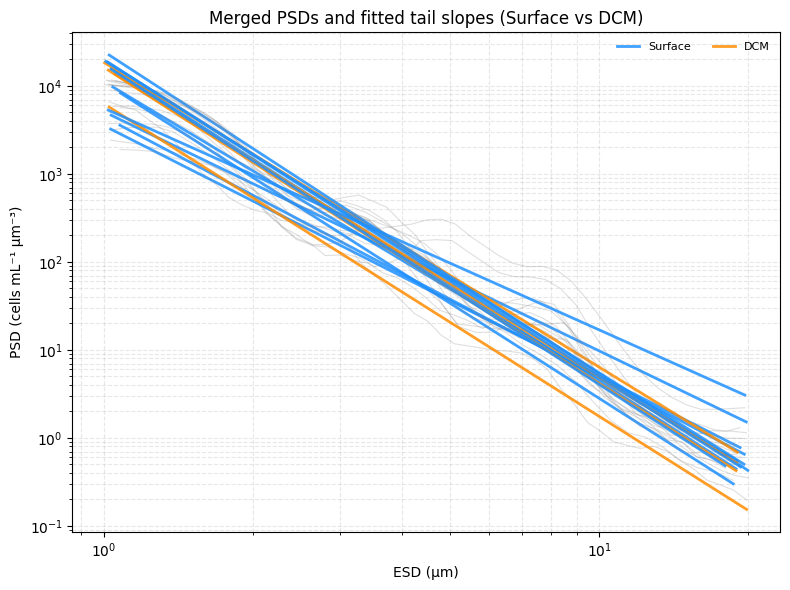

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

depth_colors = {
    "Surface": "dodgerblue",
    "DCM": "darkorange",
}

# Make it easy to look up slope info by (cast, niskin)
slope_lookup = slope_df.set_index(["cruise", "cast", "niskin"])

for (cruise_val, cc, nn), grp in merged_smooth.groupby(["cruise", "cast", "niskin"]):

    # make sure we have slope info for this bottle
    if (cruise_val, cc, nn) not in slope_lookup.index:
        continue

    srow = slope_lookup.loc[(cruise_val, cc, nn)]

    depth_cat = srow.get("depth_cat", np.nan)
    if depth_cat not in ["Surface", "DCM"]:
        continue  # skip Others or NaNs

    slope = srow[f"{metric}_PSD_slope"]
    intercept = srow[f"{metric}_PSD_intercept"]
    v_min_fit = srow["v_min_fit"]
    v_max_fit = srow["v_max_fit"]

    # skip if slope calculations failed
    if not np.isfinite(slope) or not np.isfinite(intercept):
        continue
    if not np.isfinite(v_min_fit) or not np.isfinite(v_max_fit):
        continue

    # x and y from merged_smooth (smoothed, trimmed PSD)
    mids = grp["bin_mid"].to_numpy()
    spec = grp["psd_total_merged_smooth"].to_numpy()

    valid = np.isfinite(spec) & (spec > 0)
    if valid.sum() < 8:
        continue

    # plot the full PSD in gray (background)
    ax.plot(mids[valid], spec[valid], color="gray", alpha=0.25, lw=0.8)

    # build the x-range for the fitted tail using stored fit limits
    x_fit = np.logspace(np.log10(v_min_fit), np.log10(v_max_fit), 50)
    logx_fit = np.log10(x_fit)
    logy_fit = intercept + slope * logx_fit
    yfit = 10**logy_fit

    # plot fitted segment, color by depth
    ax.plot(
        x_fit,
        yfit,
        lw=2,
        color=depth_colors[depth_cat],
        alpha=0.85,
        label=depth_cat,
    )

# --- format ---
ax.set_xscale("log")
ax.set_yscale("log")
if metric == "Biovolume":
    ax.set_xlabel("Biovolume (µm³)")
else:
    ax.set_xlabel("ESD (µm)")
ax.set_ylabel("PSD (cells mL⁻¹ µm⁻³)")
ax.set_title("Merged PSDs and fitted tail slopes (Surface vs DCM)")
ax.grid(True, which="both", ls="--", alpha=0.3)

# simplify legend (unique entries)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), ncol=2, fontsize=8, frameon=False)

plt.tight_layout()
plt.show()


In [48]:
slope_all = slope_df.drop(columns=["v_min_fit", "v_max_fit"])
slope_all

,cruise,cast,niskin,station,depth_cat,ESD_PSD_slope,ESD_PSD_intercept
0,en608,1,19,L1,Surface,-2.719311,3.708459
1,en608,4,12,L2,Surface,-2.849254,3.550013
2,en608,8,16,L4,Surface,-2.966868,3.650949
3,en608,9,16,L5,Surface,-3.373839,4.050920
4,en608,12,18,L6,Surface,-3.590795,4.041001
5,en608,14,13,L7,DCM,-3.553325,3.798766
6,en608,14,22,L7,Surface,-3.609515,4.255951
7,en608,15,15,NaN,DCM,-3.464563,4.269307
8,en608,15,19,NaN,Surface,-3.661505,4.391728
9,en608,19,11,L11,DCM,-3.522654,4.215392


# Export Size and Shape Metrics

In [49]:
# Step 1: build use_df (cells kept after L_cut logic)
use_records = []

for (cruise_val, cast_val, niskin_val), sub in long_df.groupby(["cruise", "cast", "niskin"]):
    sub = sub.dropna(subset=["Biovolume", "source"]).copy()
    if sub.empty:
        continue

    if L_cut is not None and np.isfinite(L_cut):
        is_att  = sub["source"].astype(str).eq("Attune")
        is_ifcb = sub["source"].astype(str).eq("IFCB")

        mask_keep = (is_att  & (sub["Biovolume"] <= L_cut)) | \
                    (is_ifcb & (sub["Biovolume"] >  L_cut))
    else:
        mask_keep = np.ones(len(sub), dtype=bool)

    use = sub[mask_keep].copy()
    if use.empty:
        continue

    # normalize cruise here so it's consistent everywhere
    use["cruise"] = str(cruise_val).lower()
    use_records.append(use)

use_df = pd.concat(use_records, ignore_index=True)
use_df.head()

,cruise,cast,niskin,station,class,group,depth_m,datetime,ap_vol,filename,...,GALD,S_to_V,shape_complexity,aspect_ratio,SurfaceArea,maxFeretDiameter,minFeretDiameter,Perimeter,Area,ESD
0,en608,1,5,L1,1.0,euk,11.591,2018-01-31 19:23:16+00:00,549.0,NESLTER_EN608_01Feb2018_phyto_CHL_SSC_C001N05.csv,...,0.789489,7.599850,1.0,1.0,1.958134,0.789489,0.789489,2.480254,0.489533,0.789489
1,en608,1,5,L1,1.0,euk,11.591,2018-01-31 19:23:16+00:00,549.0,NESLTER_EN608_01Feb2018_phyto_CHL_SSC_C001N05.csv,...,1.572437,3.815732,1.0,1.0,7.767774,1.572437,1.572437,4.939958,1.941944,1.572437
2,en608,1,5,L1,1.0,euk,11.591,2018-01-31 19:23:16+00:00,549.0,NESLTER_EN608_01Feb2018_phyto_CHL_SSC_C001N05.csv,...,1.094244,5.483236,1.0,1.0,3.761650,1.094244,1.094244,3.437670,0.940413,1.094244
3,en608,1,5,L1,1.0,euk,11.591,2018-01-31 19:23:16+00:00,549.0,NESLTER_EN608_01Feb2018_phyto_CHL_SSC_C001N05.csv,...,1.850207,3.242880,1.0,1.0,10.754513,1.850207,1.850207,5.812598,2.688628,1.850207
4,en608,1,5,L1,1.0,euk,11.591,2018-01-31 19:23:16+00:00,549.0,NESLTER_EN608_01Feb2018_phyto_CHL_SSC_C001N05.csv,...,1.496748,4.008691,1.0,1.0,7.037966,1.496748,1.496748,4.702172,1.759491,1.496748


In [50]:
use_df.columns

Index(['cruise', 'cast', 'niskin', 'station', 'class', 'group', 'depth_m',
       'datetime', 'ap_vol', 'filename', 'source', 'Biovolume', 'ml_analyzed',
       'GALD', 'S_to_V', 'shape_complexity', 'aspect_ratio', 'SurfaceArea',
       'maxFeretDiameter', 'minFeretDiameter', 'Perimeter', 'Area', 'ESD'],
      dtype='object')

In [51]:
def trimmed_stats(series, q_low=0.05, q_high=0.95):
    """
    Return min, max, mean, median, stdev for a series,
    after trimming to [q_low, q_high] percentiles.
    """
    s = series.dropna()
    if s.empty:
        return dict(min=np.nan, max=np.nan, mean=np.nan,
                    median=np.nan, std=np.nan)

    lo = s.quantile(q_low)
    hi = s.quantile(q_high)
    s_trim = s[(s >= lo) & (s <= hi)]

    if s_trim.empty:
        s_trim = s  # fallback if trimming removed everything

    return dict(
        min=s_trim.min(),
        max=s_trim.max(),
        mean=s_trim.mean(),
        median=s_trim.median(),
        std=s_trim.std()
    )


In [52]:
def first_non_null(x):
    x = x.dropna()
    return x.iloc[0] if not x.empty else np.nan

cols = ["Biovolume", "ESD", "SurfaceArea", "S_to_V", "maxFeretDiameter"]

shape_records = []

for (cruise_val, cast_val, niskin_val), grp in use_df.groupby(["cruise", "cast", "niskin"]):

    rec = {
        "cruise": cruise_val,
        "cast": cast_val,
        "niskin": niskin_val,
        "station": first_non_null(grp["station"]) if "station" in grp.columns else np.nan,
        "n_cells_shape": len(grp),
    }

    for col in cols:
        if col in grp.columns:
            stats = trimmed_stats(grp[col], q_low=0.05, q_high=0.95)
        else:
            stats = dict(min=np.nan, max=np.nan,
                         mean=np.nan, median=np.nan, std=np.nan)

        rec[f"{col}_min"]    = stats["min"]
        rec[f"{col}_max"]    = stats["max"]
        rec[f"{col}_mean"]   = stats["mean"]
        rec[f"{col}_median"] = stats["median"]
        rec[f"{col}_std"]    = stats["std"]

    shape_records.append(rec)

shape_summary = pd.DataFrame(shape_records)
shape_summary.head()


,cruise,cast,niskin,station,n_cells_shape,Biovolume_min,Biovolume_max,Biovolume_mean,Biovolume_median,Biovolume_std,...,S_to_V_min,S_to_V_max,S_to_V_mean,S_to_V_median,S_to_V_std,maxFeretDiameter_min,maxFeretDiameter_max,maxFeretDiameter_mean,maxFeretDiameter_median,maxFeretDiameter_std
0,en608,1,5,L1,6190,0.784202,1562.844050,131.409077,101.891943,157.038128,...,0.242367,5.244145,0.934414,0.446270,1.214518,1.144133,50.934514,9.611082,9.203735,5.870577
1,en608,1,19,L1,6174,0.835755,2103.624994,147.345266,95.696145,214.353879,...,0.218721,5.134023,0.909483,0.459500,1.189573,1.168674,46.793669,9.631709,8.967309,5.894760
2,en608,4,12,L2,5857,0.637044,1443.092468,104.192231,54.869156,142.816573,...,0.249470,5.620318,0.880372,0.544170,1.090211,1.067555,37.562424,8.650956,7.809744,4.874191
3,en608,8,12,L4,5056,0.626557,1465.990042,97.320081,54.401084,147.499450,...,0.247595,5.651502,0.906777,0.537582,1.153301,1.061665,32.714826,7.563222,6.972211,3.905739
4,en608,8,16,L4,4983,0.614945,1578.376659,108.250421,60.434615,168.278498,...,0.233131,5.686855,0.912347,0.519987,1.168249,1.055065,34.371892,7.712500,7.092666,4.237932


In [53]:
combined = slope_all.merge(
    shape_summary,
    on=["cruise", "cast", "niskin", "station"],
    how="left"
)

In [54]:
out_metrics = os.path.join(output_dir, f"{cruise}_size_shape_metrics.csv")
shape_summary.to_csv(out_metrics, index=False)
print("Saved size + shape:", out_metrics)

Saved size + shape: C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\IFCB_Attune\en608_size_shape_metrics.csv


In [55]:
slope_metrics = os.path.join(output_dir, f"{cruise}_{metric}_slope_psd.csv")
slope_all.to_csv(slope_metrics, index=False)
print("Saved PSD metrics:", out_metrics)

Saved PSD metrics: C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\IFCB_Attune\en608_size_shape_metrics.csv
